In [1]:
#Importar librerias de Python
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import pickle
import cv2 
#Importar modulos de Util
import util.Reconstruction3d as Res3d
import util.MarkerAruco as MarkerAruco
import util.Depth_Anything_V2_Simple as Depth_Anything_V2_Simple 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


xFormers not available
xFormers not available


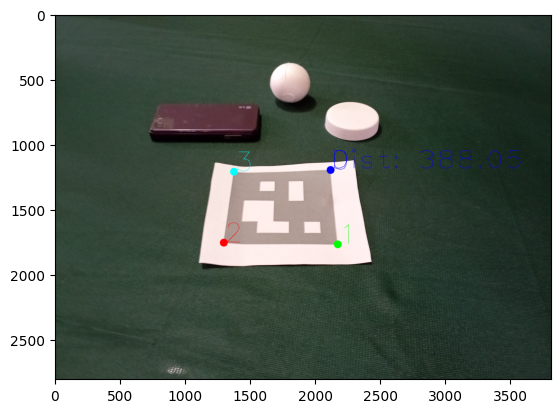

In [3]:
#Lectura de imagen
#"./content/Test_Images/IMG_20250202_122826.jpg"
img = cv2.cvtColor(cv2.imread("./content/Test_Images_Volumen/11.jpg"), cv2.COLOR_BGR2RGB) 

#Se cargar la configuracion de la camara
cameraMatrix = pickle.load(open("./calibration/cameraMatrix.pkl", "rb"))
dist = pickle.load(open("./calibration/dist.pkl", "rb"))

#Estimacion de parametros geometricos
parameter_Marker_geometry = MarkerAruco.geometry_estimation(img, 80.3, MarkerAruco.ARUCO_DICT["DICT_5x5_50"], cameraMatrix, dist)
#Eliminacion de distorsion en la imagen
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))
mapx, mapy = cv2.initUndistortRectifyMap(cameraMatrix, dist, None, newcameramtx, (w,h), 5)
img_dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
x, y, w, h = roi
img_dst= img_dst[y:y+h, x:x+w]
#Identificacion de Esquinas
parameter_Marker_corners = MarkerAruco.location_corners(img_dst, MarkerAruco.ARUCO_DICT["DICT_5x5_50"])
#Dibujamos las esquinas y mostramos distancia
img_marker = MarkerAruco.draw_parameter_detection(img_dst, parameter_Marker_geometry, parameter_Marker_corners)
#Vizualisamos resusltados
plt.imshow(img_marker)


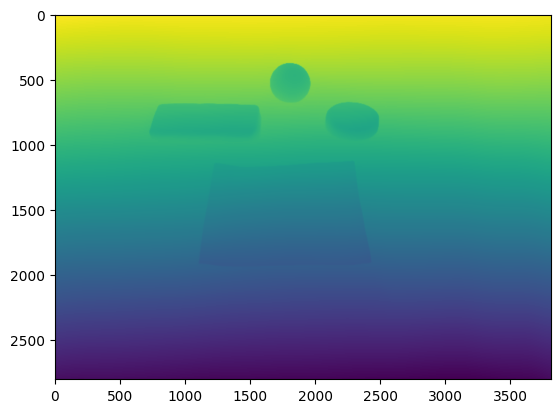

In [4]:
#Instancia del modelo Depth_Anything_V2
depthAythingV2 = Depth_Anything_V2_Simple.ModelDepthAnythingV2('vits',5) 
#Estimamos profundidar de la imagen
img_depth = depthAythingV2.predictionDepth(img_dst)
plt.imshow(img_depth)

In [5]:
# Distancia real conocida en mm
D_real = 111.6  
#Coordenadas u,v,w
u1,u2 = int(parameter_Marker_corners["top_left"][0]) , int(parameter_Marker_corners["bottom_right"][0])
v1,v2 = int(parameter_Marker_corners["top_left"][1]) , int(parameter_Marker_corners["bottom_right"][1])
w1 = img_depth[v1, u1]
w2 = img_depth[v2, u2]
#Calculo factor de escala
scale_factor = abs((D_real*np.sin(np.pi - parameter_Marker_geometry["theta_XY"])))/abs((w2 - w1))

#Paso de coordenadas relativa a absolutos del mapa de profundidad
image_depth_esc = img_depth*scale_factor #(mm)
image_depth_absolute = image_depth_esc - image_depth_esc[int(parameter_Marker_corners["top_left"][0]), int(parameter_Marker_corners["top_left"][1])] + parameter_Marker_geometry["distance"]
print(image_depth_absolute)


[[700.77833354 701.00524981 701.23214096 ... 694.55837249 695.40096043
  696.24384965]
 [700.71046956 700.90964269 701.10884092 ... 694.18094029 694.87476978
  695.56882523]
 [700.64260558 700.81406068 700.98551577 ... 693.80348299 694.34857914
  694.89382593]
 ...
 [300.94715852 300.55210128 300.15706914 ... 293.48490751 293.56693178
  293.64898117]
 [302.14387944 301.59034737 301.03686552 ... 293.28741654 293.35706311
  293.42670969]
 [303.34057525 302.62859347 301.9166619  ... 293.08995069 293.14719444
  293.20448841]]


Volumen Alimento: 38.56 cm^3


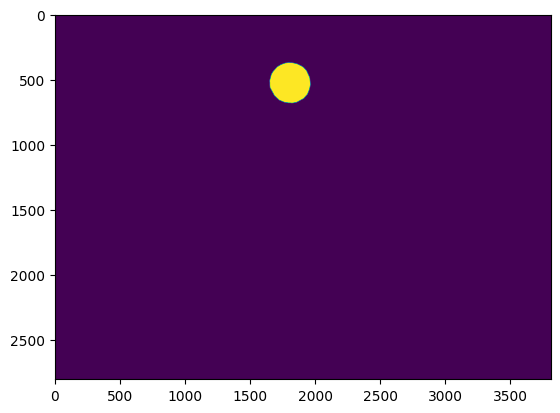

In [8]:
#Leer Archivo que contiene la segmentacion
segmentation_file = "./content/Label_Volumen/Img_dis_11_png.txt"   #label_image_undistorsion.txt
with open(segmentation_file, "r") as f:
    lines = f.readlines()
#Contruir mascara deacuerdo al archivo de segmentacion
class_img = 2
width_dst, height_dst = int(np.shape(img_dst)[1]), int(np.shape(img_dst)[0])
mask = Res3d.lines_to_mark_segmentation(lines, class_img, height_dst, width_dst)
plt.imshow(mask)
#Calculo volumen de la segmentacion
normal = - parameter_Marker_geometry["normal"]
volumen = Res3d.calculation_volumen(image_depth_absolute, mask, normal, cameraMatrix)
print(f"Volumen Alimento: {round(volumen,2)} cm^3")



In [7]:
#Creacion nube de puntos de la segmentacion
pcd = Res3d.depth_to_point_cloud_segmented(image_depth_absolute, mask, normal, cameraMatrix)
#Visualizacion Nube de puntos segmentada
o3d.visualization.draw_geometries([pcd])


In [138]:
#Creacion nube de puntos de la escena
pcd_completed = Res3d.depth_to_point_cloud_scene(image_depth_absolute, img_dst, cameraMatrix)
o3d.visualization.draw_geometries([pcd_completed])
##################################################################################################################################################